[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2024-11-09 18:56:38,535 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpi0xtln53


100%|██████████| 253M/253M [00:15<00:00, 17.3MB/s]

2024-11-09 18:56:54,363 copying /tmp/tmpi0xtln53 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-11-09 18:56:55,305 removing temp file /tmp/tmpi0xtln53


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Error for id 83: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]
Error for id 187: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]
Metrics for vader:
Negative Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Neutral Precision: 0.9880, Recall: 0.9880, F1 Score: 0.9880
Positive Precision: 0.0080, Recall: 0.0080, F1 Score: 0.0080
--------------------------------------------------
Metrics for roberta:
Negative Precision: 0.1305, Recall: 0.1305, F1 Score: 0.1305
Neutral Precision: 0.0402, Recall: 0.0402, F1 Score: 0.0402
Positive Precision: 0.7390, Recall: 0.7390, F1 Score: 0.7390
--------------------------------------------------
Metrics for textblob:
Negative Precision: 0.1084, Recall: 0.1084, F1 Score: 0.1084
Neutral Precision: 0.0221, Recall: 0.0221, F1 Score: 0.0221
Positive Pre

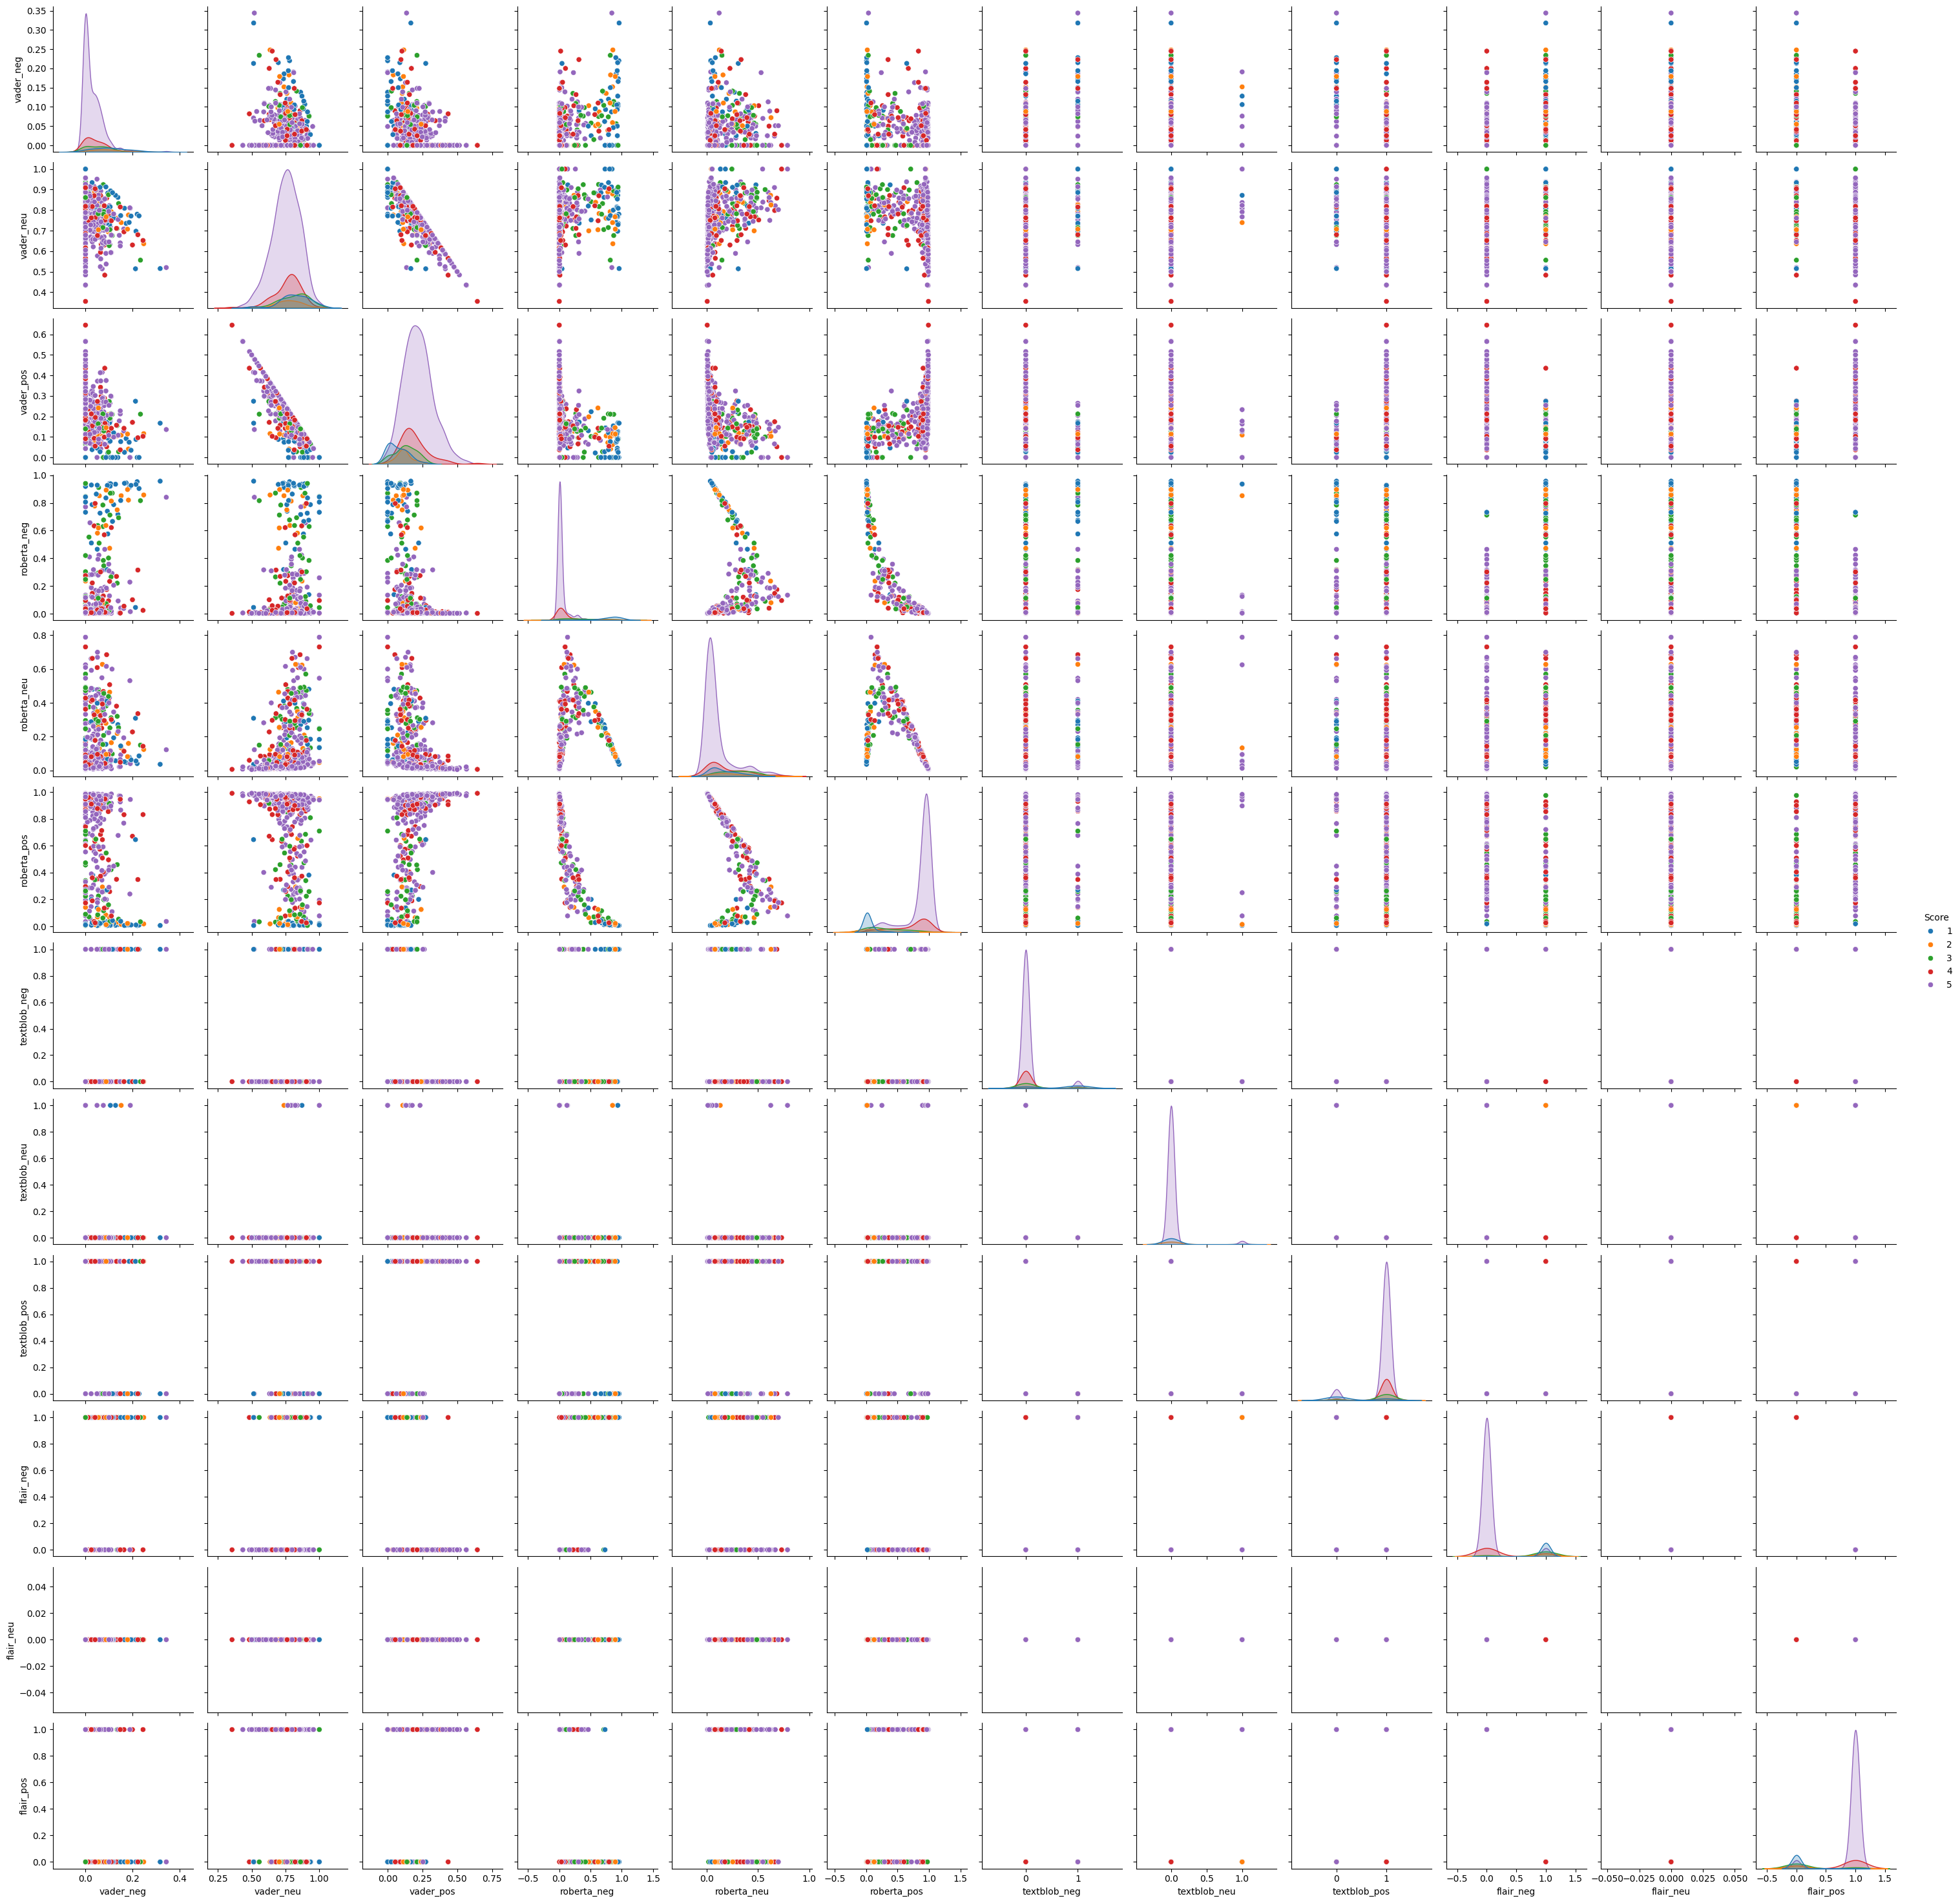

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence

# Load the dataset
df = pd.read_csv("/content/Reviews.csv")
df = df.head(500)

# Initialize SentimentIntensityAnalyzer and RoBERTa tokenizer/model
sia = SentimentIntensityAnalyzer()
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Initialize Flair Text Classifier
flair_classifier = TextClassifier.load('en-sentiment')

# Function for RoBERTa sentiment analysis
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

# Function for TextBlob sentiment analysis
def polarity_scores_textblob(example):
    blob = TextBlob(example)
    polarity = blob.sentiment.polarity
    return {'textblob_pos': 1 if polarity > 0 else 0, 'textblob_neg': 1 if polarity < 0 else 0, 'textblob_neu': 1 if polarity == 0 else 0}

# Function for Flair sentiment analysis
def polarity_scores_flair(example):
    sentence = Sentence(example)
    flair_classifier.predict(sentence)
    score = sentence.labels[0]
    return {'flair_pos': 1 if score.value == 'POSITIVE' else 0, 'flair_neg': 1 if score.value == 'NEGATIVE' else 0, 'flair_neu': 1 if score.value == 'NEUTRAL' else 0}

# Initialize a dictionary to store results
res = {}

# Loop through the DataFrame and apply all five sentiment analysis models
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']

        # Perform Vader sentiment analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        # Perform Roberta sentiment analysis
        roberta_result = polarity_scores_roberta(text)

        # Perform TextBlob sentiment analysis
        textblob_result = polarity_scores_textblob(text)

        # Perform Flair sentiment analysis
        flair_result = polarity_scores_flair(text)

        # Merge all results into a single dictionary
        both = {**vader_result_rename, **roberta_result, **textblob_result, **flair_result}

        # Store results in the 'res' dictionary
        res[myid] = both
    except Exception as e:
        print(f'Error for id {myid}: {str(e)}')

# Convert the results into a DataFrame and merge with the original dataframe
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Function to calculate precision, recall, and F1 score for each model
def calculate_metrics(df):
    metrics = {}

    # Calculate Precision, Recall, and F1 Score for each sentiment category (Negative, Neutral, Positive)
    for model in ['vader', 'roberta', 'textblob', 'flair']:
        TP_neg = ((df[f'{model}_neg'] > 0.5)).sum()
        TP_neu = ((df[f'{model}_neu'] > 0.5)).sum()
        TP_pos = ((df[f'{model}_pos'] > 0.5)).sum()

        FP_neg = ((df[f'{model}_neg'] <= 0.5)).sum()
        FP_neu = ((df[f'{model}_neu'] <= 0.5)).sum()
        FP_pos = ((df[f'{model}_pos'] <= 0.5)).sum()

        FN_neg = ((df[f'{model}_neg'] <= 0.5)).sum()
        FN_neu = ((df[f'{model}_neu'] <= 0.5)).sum()
        FN_pos = ((df[f'{model}_pos'] <= 0.5)).sum()

        precision_neg = TP_neg / (TP_neg + FP_neg) if (TP_neg + FP_neg) != 0 else 0
        recall_neg = TP_neg / (TP_neg + FN_neg) if (TP_neg + FN_neg) != 0 else 0
        f1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg) if (precision_neg + recall_neg) != 0 else 0

        precision_neu = TP_neu / (TP_neu + FP_neu) if (TP_neu + FP_neu) != 0 else 0
        recall_neu = TP_neu / (TP_neu + FN_neu) if (TP_neu + FN_neu) != 0 else 0
        f1_neu = 2 * (precision_neu * recall_neu) / (precision_neu + recall_neu) if (precision_neu + recall_neu) != 0 else 0

        precision_pos = TP_pos / (TP_pos + FP_pos) if (TP_pos + FP_pos) != 0 else 0
        recall_pos = TP_pos / (TP_pos + FN_pos) if (TP_pos + FN_pos) != 0 else 0
        f1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos) if (precision_pos + recall_pos) != 0 else 0

        metrics[model] = {
            'precision_neg': precision_neg,
            'recall_neg': recall_neg,
            'f1_neg': f1_neg,
            'precision_neu': precision_neu,
            'recall_neu': recall_neu,
            'f1_neu': f1_neu,
            'precision_pos': precision_pos,
            'recall_pos': recall_pos,
            'f1_pos': f1_pos
        }

    return metrics

# Calculate metrics for all models
metrics = calculate_metrics(results_df)

# Print comparison of all 5 models
for model, scores in metrics.items():
    print(f"Metrics for {model}:")
    print(f"Negative Precision: {scores['precision_neg']:.4f}, Recall: {scores['recall_neg']:.4f}, F1 Score: {scores['f1_neg']:.4f}")
    print(f"Neutral Precision: {scores['precision_neu']:.4f}, Recall: {scores['recall_neu']:.4f}, F1 Score: {scores['f1_neu']:.4f}")
    print(f"Positive Precision: {scores['precision_pos']:.4f}, Recall: {scores['recall_pos']:.4f}, F1 Score: {scores['f1_pos']:.4f}")
    print("-" * 50)

# Visualize the results using Seaborn and Matplotlib
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',
                  'textblob_neg', 'textblob_neu', 'textblob_pos',
                  'flair_neg', 'flair_neu', 'flair_pos'],
            hue='Score',
            palette='tab10')
plt.show()

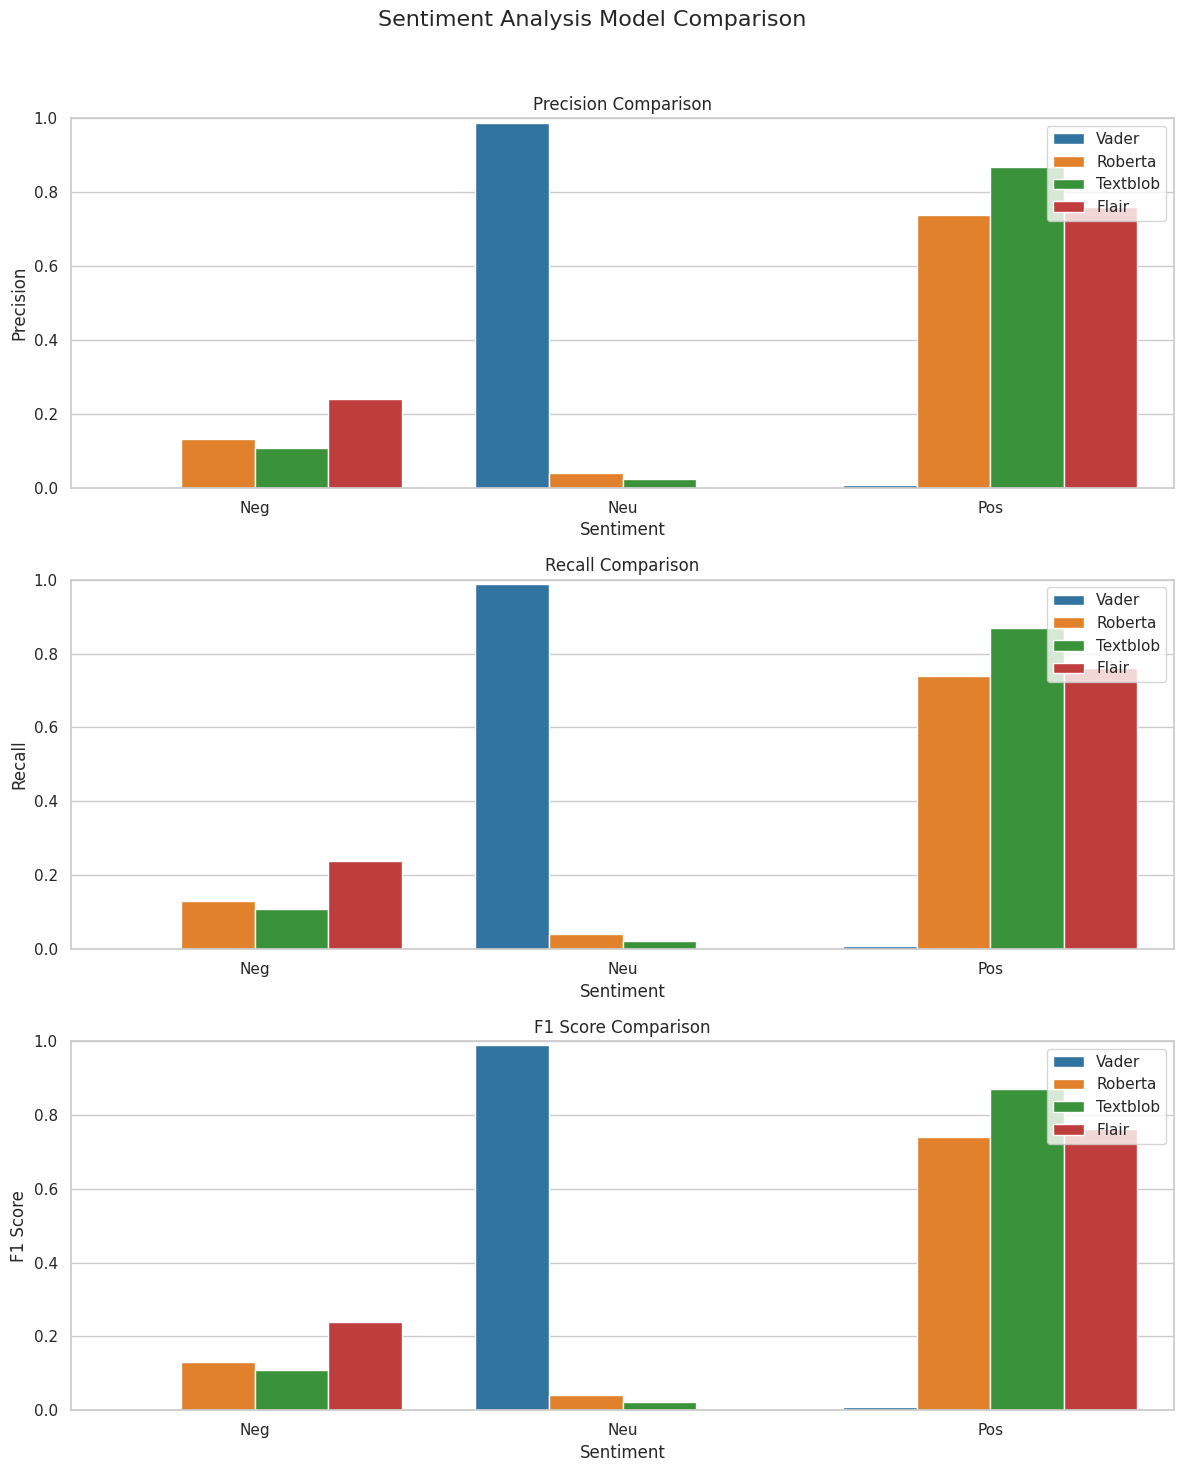

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up data for plotting
model_metrics = {
    'vader': metrics['vader'],
    'roberta': metrics['roberta'],
    'textblob': metrics['textblob'],
    'flair': metrics['flair']
}

# Convert metrics into a DataFrame for easier plotting
plot_data = []
for model, scores in model_metrics.items():
    for sentiment in ['neg', 'neu', 'pos']:
        plot_data.append({
            'Model': model.capitalize(),
            'Sentiment': sentiment.capitalize(),
            'Precision': scores[f'precision_{sentiment}'],
            'Recall': scores[f'recall_{sentiment}'],
            'F1 Score': scores[f'f1_{sentiment}']
        })

plot_df = pd.DataFrame(plot_data)

# Set the style
sns.set(style="whitegrid")

# Plot Precision, Recall, and F1 Score for each model and sentiment
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('Sentiment Analysis Model Comparison', fontsize=16)

# Precision Plot
sns.barplot(data=plot_df, x='Sentiment', y='Precision', hue='Model', ax=axes[0], palette='tab10')
axes[0].set_title('Precision Comparison')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='upper right')

# Recall Plot
sns.barplot(data=plot_df, x='Sentiment', y='Recall', hue='Model', ax=axes[1], palette='tab10')
axes[1].set_title('Recall Comparison')
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper right')

# F1 Score Plot
sns.barplot(data=plot_df, x='Sentiment', y='F1 Score', hue='Model', ax=axes[2], palette='tab10')
axes[2].set_title('F1 Score Comparison')
axes[2].set_ylim(0, 1)
axes[2].legend(loc='upper right')

# Display plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
from graphviz import Digraph

# Initialize the graph
flowchart = Digraph(comment="Model Metrics Visualization Flowchart")

# Add nodes for main steps in the code
flowchart.node("A", "Start")
flowchart.node("B", "Define model_metrics dictionary\nwith precision, recall, and F1")
flowchart.node("C", "Convert metrics to DataFrame\nwith sentiment scores per model")
flowchart.node("D", "Initialize seaborn and matplotlib\nstyles for the plot")
flowchart.node("E", "Create figure and subplots")
flowchart.node("F", "Plot Precision, Recall, and F1\nfor each model and sentiment")
flowchart.node("G", "Configure titles, legend, and limits\nfor each plot")
flowchart.node("H", "Display the plots")
flowchart.node("I", "End")

# Add edges to show the flow
flowchart.edge("A", "B")
flowchart.edge("B", "C")
flowchart.edge("C", "D")
flowchart.edge("D", "E")
flowchart.edge("E", "F")
flowchart.edge("F", "G")
flowchart.edge("G", "H")
flowchart.edge("H", "I")

# Render the flowchart
flowchart.render("model_metrics_flowchart", format="png", view=True)


'model_metrics_flowchart.png'